##Imports and downloading dataset

In [73]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import numpy as np
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
from scipy.io import wavfile
from sklearn.model_selection import train_test_split
from tensorflow.python.keras.layers import Dense
import tensorflow
import tensorflow.keras
from tensorflow.keras import models, layers
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPool1D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from keras.utils import np_utils
from tensorflow.keras.utils import plot_model
from keras import regularizers
import keras,os
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from keras.callbacks import ReduceLROnPlateau,ModelCheckpoint,EarlyStopping
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Activation, Flatten,Dense,Input,Dropout,BatchNormalization,Conv1D,MaxPooling2D
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
from tqdm import tqdm
import random
random.seed(42)

In [31]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
from keras import backend as K
K._get_available_gpus()

[]

[]

In [33]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/Kaggle_ds"

In [ ]:
if not os.path.exists('/content/drive/MyDrive/Kaggle_ds/'):
    os.makedirs('/content/drive/MyDrive/Kaggle_ds/')
    %cd /content/drive/MyDrive/Kaggle_ds/

In [ ]:
%cd /content/drive/MyDrive/Kaggle_ds/

/content/drive/MyDrive/Kaggle_ds


In [ ]:
%ls /content/drive/MyDrive/Kaggle_ds/

 2dmodel1.best.hdf5            bestelbest.hdf5                  kaggle.json
 2dmodel1_lr0.0001.best.hdf5   Crema/                           Ravdess/
 2dmodel1_lr0.0005.best.hdf5   CREMA_df_features.csv            Savee/
 2dmodel2.best.hdf5           ' CREMA_df_features_mfcc20.csv'   spectro.npy
 2dmodel3.best.hdf5            CREMA_df_features_noise.csv      Tess/
 2dmodelVGG.best.hdf5          CREMA_df_features_shift.csv


In [9]:
!kaggle datasets download -d dmitrybabko/speech-emotion-recognition-en --unzip 

 99% 979M/987M [00:08<00:00, 57.9MB/s]
100% 987M/987M [00:08<00:00, 119MB/s] 
User cancelled operation


In [10]:
CREMA = '/content/drive/MyDrive/Kaggle_ds/Crema/'
%cd /content/drive/MyDrive/Kaggle_ds/Crema

/content/drive/MyDrive/Kaggle_ds/Crema


In [11]:
#Get all filenames into a list
dir_list = os.listdir('/content/drive/MyDrive/Kaggle_ds/Crema/')
dir_list.sort()
dir_list[:5]

['1001_DFA_ANG_XX.wav',
 '1001_DFA_DIS_XX.wav',
 '1001_DFA_FEA_XX.wav',
 '1001_DFA_HAP_XX.wav',
 '1001_DFA_NEU_XX.wav']

In [ ]:
%ls /content/drive/MyDrive/Kaggle_ds/Crema/

In [ ]:
emotionG_label = []
gender = []
emotion = []
path = []
female_ids = [1002,1003,1004,1006,1007,1008,1009,1010,1012,1013,1018,1020,1021,
              1024,1025,1028,1029,1030,1037,1043,1046,1047,1049,1052,1053,1054,
              1055,1056,1058,1060,1061,1063,1072,1073,1074,1075,1076,1078,1079,
              1082,1084,1089,1091]

temp_dict = {"SAD":"sad", "ANG": "angry", "DIS":"disgust", "FEA":"fear", 
             "HAP":"happy", "NEU":"neutral"}

def get_emotion_crema(filename, ids=female_ids, dc=temp_dict):
  filename = filename.split("_")
  emotionG1 = dc[filename[2]]
  if int(filename[0]) in ids:
    emotionG2 = "_female"
  else:
    emotionG2 = "_male"
  emotionG_label = emotionG1 + emotionG2
  return (emotionG_label, emotionG1, emotionG2[1:])


for i in dir_list: 
  emotionG_label.append(get_emotion_crema(i)[0])
  emotion.append(get_emotion_crema(i)[1])
  gender.append(get_emotion_crema(i)[2])
  path.append(i)

In [ ]:
CREMA_df = pd.DataFrame(emotionG_label, columns = ['emotionG_label'])
CREMA_df['source'] = 'CREMA'
CREMA_df = pd.concat([CREMA_df,pd.DataFrame(gender, columns = ['gender'])],axis=1)
CREMA_df = pd.concat([CREMA_df,pd.DataFrame(emotion, columns = ['emotion'])],axis=1)
CREMA_df = pd.concat([CREMA_df,pd.DataFrame(path, columns = ['path'])],axis=1)

In [ ]:
CREMA_df.head()

In [ ]:
CREMA_df.emotionG_label.value_counts()

In [ ]:
CREMA_df.head()

In [ ]:
CREMA_df_summary = CREMA_df.pivot_table(index='emotion', columns='gender', aggfunc=len, values = 'source')
CREMA_df_summary

In [ ]:
CREMA_df_summary.plot(kind='barh')

In [ ]:
n_files = CREMA_df.shape[0]

# choose random number
rnd = np.random.randint(0,n_files)

# use the Librosa library to load and plot the random speech

fname = CREMA_df.path[rnd] 
sampling_rate, data = wavfile.read(fname)

plt.figure(figsize=(15, 5))
info = CREMA_df.iloc[rnd].values
title_txt = f'{info[2]} voice - {info[0]} emotion (speech) - [{os.path.basename(fname)}]'
plt.title(title_txt.upper(), size=16)
plt.plot(data)

# play the audio 
ipd.Audio(fname)

In [ ]:
fname = CREMA_df.path[rnd] 
y, sr = librosa.load(fname)

# Compute mel spectrogram
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)

# Convert to log scale (dB) using the peak power as reference
log_S = librosa.power_to_db(S, ref=np.max)

# Plot mel spectrogram
plt.figure(figsize=(12, 4))
librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel')
plt.title('Mel spectrogram')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()
plt.show()

In [ ]:
def display_audio(aud_name):
  path= '/content/drive/MyDrive/Kaggle_ds/Crema/'+aud_name
  x, sr = librosa.load(path)
  ipd.display(ipd.Audio(x, rate=sr))
  plt.figure(figsize=(14, 5))
  librosa.display.waveshow(x, sr=sr)
  plt.show()
     

# sad
print(" Sad ")
display_audio('1001_DFA_SAD_XX.wav')
# angry
print("\n\n Angry ")
display_audio('1001_DFA_ANG_XX.wav')
# disgust
print("\n\n Disgust ")
display_audio('1001_DFA_DIS_XX.wav')
# fear
print("\n\n Fear ")
display_audio('1001_DFA_FEA_XX.wav')
# happy
print("\n\n Happy ")
display_audio('1001_DFA_HAP_XX.wav')
# neutral
print("\n\n Neutral ")
display_audio('1001_DFA_NEU_XX.wav')

##Feature extraction and spliting

In [ ]:
def prepare_data(df, n):
    X = np.empty(shape=(df.shape[0], n, 216, 1))
    audio_duration=2.5
    input_length = sampling_rate * audio_duration
    
    cnt = 0
    for fname in tqdm(df.path):
        file_path = fname
        data, _ = librosa.load(file_path, sr=sampling_rate
                               ,duration=2.5
                               ,offset=0.5
                              )

        # Random offset / Padding
        if len(data) > input_length:
            max_offset = len(data) - input_length
            offset = np.random.randint(max_offset)
            data = data[offset:(input_length+offset)]
        else:
            if input_length > len(data):
                max_offset = input_length - len(data)
                offset = np.random.randint(max_offset)
            else:
                offset = 0
            data = np.pad(data, (offset, int(input_length) - len(data) - offset), "constant")
        # Log-melspectrogram
        melspec = librosa.feature.melspectrogram(y=data, n_mels=n)   
        logspec = librosa.amplitude_to_db(melspec)
        logspec = np.expand_dims(logspec, axis=-1)
        X[cnt,] = logspec
            
        cnt += 1
    
    return X


## Getting spectrogram

In [ ]:
sampling_rate=44100
n_mfcc = 30
spectro = prepare_data(CREMA_df,n_mfcc)


100%|██████████| 7442/7442 [1:32:51<00:00, 1.2it/s]



In [ ]:
np.save('/content/drive/MyDrive/Kaggle_ds/spectro.npy', spectro)

In [36]:
spectro=np.load('/content/drive/MyDrive/Kaggle_ds/spectro.npy')

In [37]:
spectro.shape

(7442, 30, 216, 1)

In [34]:
labels=CREMA_df['emotion']

In [35]:
labels.shape

(7442,)

# Initial CNN MODEL

In [ ]:
def get_f1(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [ ]:
def create_model2d():
  input_shape=(30,216,1)
  CNNmodel = models.Sequential()
  CNNmodel.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
  CNNmodel.add(layers.MaxPooling2D((2, 2)))
  CNNmodel.add(layers.Dropout(0.2))
  CNNmodel.add(layers.Conv2D(64, (3, 3), activation='relu'))
  CNNmodel.add(layers.MaxPooling2D((2, 2)))
  CNNmodel.add(layers.Dropout(0.2))
  CNNmodel.add(layers.Conv2D(64, (3, 3), activation='relu'))
  CNNmodel.add(layers.Flatten())
  CNNmodel.add(layers.Dense(64, activation='relu'))
  CNNmodel.add(layers.Dropout(0.2))
  CNNmodel.add(layers.Dense(32, activation='relu'))
  CNNmodel.add(layers.Dense(6, activation='softmax')) 
  opt=tensorflow.keras.optimizers.RMSprop(
    learning_rate=0.001
)
  CNNmodel.compile(loss = 'categorical_crossentropy',optimizer = 'Adam',metrics = ['accuracy',get_f1])
  return CNNmodel

In [ ]:
# call back function after epoch end for storing accuracy and loss and f1 score trainig and validation
class myCallback(tensorflow.keras.callbacks.Callback):
    accuracy = []
    val_accuracy = []
    loss = []
    val_loss = []
    f1 = []
    val_f1 = []
    epoch_num = 0
    def __init__(self, logs={}):
        self.accuracy = []
        self.val_accuracy = []
        self.loss = []
        self.val_loss = []
        self.f1 = []
        self.val_f1 = []
        self.epoch_num = 0

    def on_epoch_end(self,epoch,logs={}):
        # get current accuracy and loss
        current_accuracy = logs.get('accuracy')
        current_val_accuracy = logs.get('val_accuracy')
        current_loss = logs.get('loss')
        current_val_loss = logs.get('val_loss')
        current_f1 = logs.get('get_f1')
        current_val_f1 = logs.get('val_get_f1')

        # append current accuracy and loss to lists
        self.accuracy.append(current_accuracy)
        self.val_accuracy.append(current_val_accuracy)
        self.loss.append(current_loss)
        self.val_loss.append(current_val_loss)
        self.f1.append(current_f1)
        self.val_f1.append(current_val_f1)

        # update epoch number
        self.epoch_num = self.epoch_num + 1



In [ ]:
X_train_val, X_test, y_train_val, y_test = train_test_split(spectro,labels, test_size=0.3, random_state=42, stratify=labels)
# Split the remaining data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.05, random_state=42, stratify=y_train_val)
print(len(X_train_val))
print(len(X_val))
print(len(X_test))

5209
261
2233


In [ ]:
# expand dimensions
x_traincnn = np.expand_dims(X_train, axis=3)
x_valcnn = np.expand_dims(X_val, axis=3)
x_testcnn=np.expand_dims(X_test,axis=3)


In [ ]:
lb = LabelEncoder()
# encode labels

y_train_lb = np_utils.to_categorical(lb.fit_transform(y_train))
y_val_lb = np_utils.to_categorical(lb.fit_transform(y_val))
y_test_lb=np_utils.to_categorical(lb.fit_transform(y_test))

In [ ]:
x_traincnn.dtype

dtype('float64')

In [ ]:
# train model
CNNmodel=create_model2d()
tensorflow.convert_to_tensor(x_traincnn, dtype=tensorflow.float64)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=20, min_lr=0.000001)
save_metric = myCallback()
es = EarlyStopping(monitor='val_accuracy', patience=100)
filepath="/content/drive/MyDrive/Kaggle_ds/2dmodel1.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
cnn_results=CNNmodel.fit(x_traincnn, y_train_lb, batch_size=16, epochs=700,
                     validation_data = (x_valcnn, y_val_lb), callbacks=[lr_reduce,checkpoint,es,save_metric])

Epoch 1/700
305/310 [============================>.] - ETA: 0s - loss: 1.8143 - accuracy: 0.2855 - get_f1: 0.1069
Epoch 1: val_accuracy improved from -inf to 0.36015, saving model to /content/drive/MyDrive/Kaggle_ds/2dmodel1.best.hdf5
310/310 [==============================] - 7s 11ms/step - loss: 1.8105 - accuracy: 0.2864 - get_f1: 0.1076 - val_loss: 1.5718 - val_accuracy: 0.3602 - val_get_f1: 0.0969 - lr: 0.0010
Epoch 2/700
304/310 [============================>.] - ETA: 0s - loss: 1.5376 - accuracy: 0.3477 - get_f1: 0.1344
Epoch 2: val_accuracy improved from 0.36015 to 0.37165, saving model to /content/drive/MyDrive/Kaggle_ds/2dmodel1.best.hdf5
310/310 [==============================] - 3s 11ms/step - loss: 1.5381 - accuracy: 0.3478 - get_f1: 0.1335 - val_loss: 1.5308 - val_accuracy: 0.3716 - val_get_f1: 0.1007 - lr: 0.0010
Epoch 3/700
305/310 [============================>.] - ETA: 0s - loss: 1.4870 - accuracy: 0.3740 - get_f1: 0.1616
Epoch 3: val_accuracy did not improve from 0.37

<Figure size 640x480 with 0 Axes>

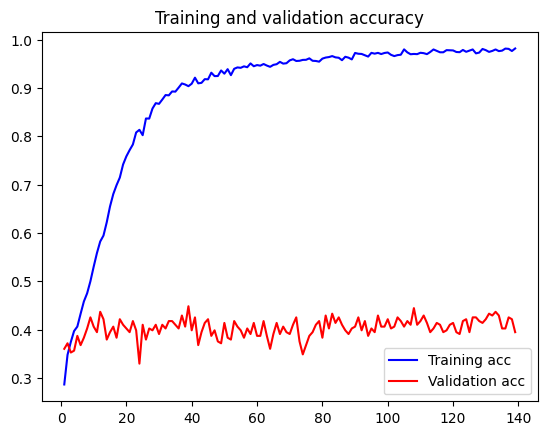

<Figure size 640x480 with 0 Axes>

In [ ]:
epochs = range(1, len(save_metric.accuracy) + 1)
plt.plot(epochs, save_metric.accuracy, 'b', label='Training acc')
plt.plot(epochs, save_metric.val_accuracy, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()


<Figure size 640x480 with 0 Axes>

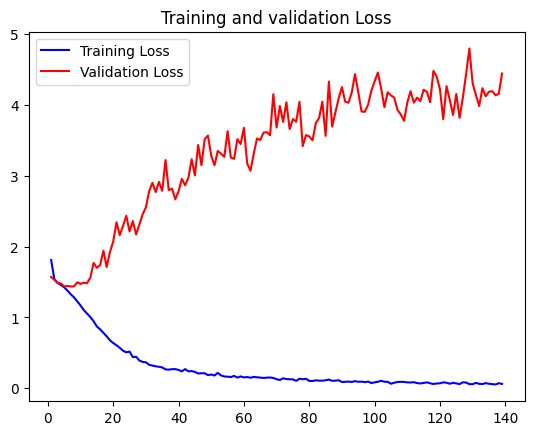

<Figure size 640x480 with 0 Axes>

In [ ]:
epochs = range(1, len(save_metric.loss) + 1)
plt.plot(epochs, save_metric.loss, 'b', label='Training Loss')
plt.plot(epochs, save_metric.val_loss, 'r', label='Validation Loss')
plt.title('Training and validation Loss')
plt.legend()
plt.figure()

<Figure size 640x480 with 0 Axes>

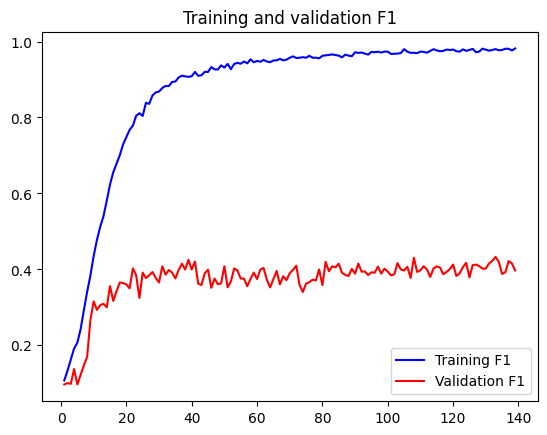

<Figure size 640x480 with 0 Axes>

In [ ]:
epochs=range(1,len(save_metric.f1)+1)
plt.plot(epochs,save_metric.f1,'b',label='Training F1')
plt.plot(epochs,save_metric.val_f1,'r',label='Validation F1')
plt.title('Training and validation F1')
plt.legend()
plt.figure()


In [ ]:
# reload the best model
filepath="/content/drive/MyDrive/Kaggle_ds/2dmodel1.best.hdf5"

CNNmodel.load_weights(filepath)

# evaluate model on test data

from sklearn.metrics import classification_report

y_pred = CNNmodel.predict(x_testcnn, batch_size=16, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

y_test_bool = np.argmax(y_test_lb, axis=1)
print(classification_report(y_test_bool, y_pred_bool))

140/140 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.56      0.66      0.61       382
           1       0.38      0.29      0.33       381
           2       0.28      0.28      0.28       381
           3       0.32      0.29      0.30       382
           4       0.43      0.33      0.37       326
           5       0.44      0.59      0.50       381

    accuracy                           0.41      2233
   macro avg       0.40      0.41      0.40      2233
weighted avg       0.40      0.41      0.40      2233



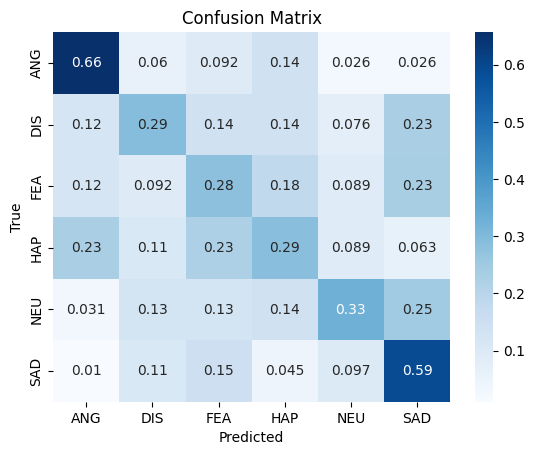

In [ ]:
cm = confusion_matrix(y_test_bool, y_pred_bool)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm, annot=True, cmap='Blues',xticklabels=['ANG','DIS','FEA','HAP','NEU','SAD'],yticklabels=['ANG','DIS','FEA','HAP','NEU','SAD'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

###Comment

 The most confusing classes here are Fear 0.28,disgust 0.29 and happy 0.29
This model yields acc 0.41 and F1-score with weighted avg 0.40 and with macro average 0.40

# Initial CNN MODEL with lr=0.0001

In [ ]:
def get_f1(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [ ]:
def create_model2d():
  input_shape=(30,216,1)
  CNNmodel = models.Sequential()
  CNNmodel.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
  CNNmodel.add(layers.MaxPooling2D((2, 2)))
  CNNmodel.add(layers.Dropout(0.2))
  CNNmodel.add(layers.Conv2D(64, (3, 3), activation='relu'))
  CNNmodel.add(layers.MaxPooling2D((2, 2)))
  CNNmodel.add(layers.Dropout(0.2))
  CNNmodel.add(layers.Conv2D(64, (3, 3), activation='relu'))
  CNNmodel.add(layers.Flatten())
  CNNmodel.add(layers.Dense(64, activation='relu'))
  CNNmodel.add(layers.Dropout(0.2))
  CNNmodel.add(layers.Dense(32, activation='relu'))
  CNNmodel.add(layers.Dense(6, activation='softmax')) 
  opt=tensorflow.keras.optimizers.RMSprop(
    learning_rate=0.0001
)
  CNNmodel.compile(loss = 'categorical_crossentropy',optimizer = 'Adam',metrics = ['accuracy',get_f1])
  return CNNmodel

In [ ]:
# call back function after epoch end for storing accuracy and loss and f1 score trainig and validation
class myCallback(tensorflow.keras.callbacks.Callback):
    accuracy = []
    val_accuracy = []
    loss = []
    val_loss = []
    f1 = []
    val_f1 = []
    epoch_num = 0
    def __init__(self, logs={}):
        self.accuracy = []
        self.val_accuracy = []
        self.loss = []
        self.val_loss = []
        self.f1 = []
        self.val_f1 = []
        self.epoch_num = 0

    def on_epoch_end(self,epoch,logs={}):
        # get current accuracy and loss
        current_accuracy = logs.get('accuracy')
        current_val_accuracy = logs.get('val_accuracy')
        current_loss = logs.get('loss')
        current_val_loss = logs.get('val_loss')
        current_f1 = logs.get('get_f1')
        current_val_f1 = logs.get('val_get_f1')

        # append current accuracy and loss to lists
        self.accuracy.append(current_accuracy)
        self.val_accuracy.append(current_val_accuracy)
        self.loss.append(current_loss)
        self.val_loss.append(current_val_loss)
        self.f1.append(current_f1)
        self.val_f1.append(current_val_f1)

        # update epoch number
        self.epoch_num = self.epoch_num + 1



In [ ]:
X_train_val, X_test, y_train_val, y_test = train_test_split(spectro,labels, test_size=0.3, random_state=42, stratify=labels)
# Split the remaining data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.05, random_state=42, stratify=y_train_val)
print(len(X_train_val))
print(len(X_val))
print(len(X_test))

5209
261
2233


In [ ]:
# expand dimensions
x_traincnn = np.expand_dims(X_train, axis=3)
x_valcnn = np.expand_dims(X_val, axis=3)
x_testcnn=np.expand_dims(X_test,axis=3)


In [ ]:
lb = LabelEncoder()
# encode labels

y_train_lb = np_utils.to_categorical(lb.fit_transform(y_train))
y_val_lb = np_utils.to_categorical(lb.fit_transform(y_val))
y_test_lb=np_utils.to_categorical(lb.fit_transform(y_test))

In [ ]:
x_traincnn.dtype

dtype('float64')

In [ ]:
# train model
CNNmodel=create_model2d()
tensorflow.convert_to_tensor(x_traincnn, dtype=tensorflow.float64)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=20, min_lr=0.000001)
save_metric = myCallback()
es = EarlyStopping(monitor='val_accuracy', patience=100)
filepath="/content/drive/MyDrive/Kaggle_ds/2dmodel1_lr0.0001.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
cnn_results=CNNmodel.fit(x_traincnn, y_train_lb, batch_size=16, epochs=700,
                     validation_data = (x_valcnn, y_val_lb), callbacks=[lr_reduce,checkpoint,es,save_metric])

Epoch 1/700
310/310 [==============================] - ETA: 0s - loss: 1.7237 - accuracy: 0.2973 - get_f1: 0.1044
Epoch 1: val_accuracy improved from -inf to 0.37165, saving model to /content/drive/MyDrive/Kaggle_ds/2dmodel1_lr0.0001.best.hdf5
310/310 [==============================] - 15s 10ms/step - loss: 1.7237 - accuracy: 0.2973 - get_f1: 0.1044 - val_loss: 1.5415 - val_accuracy: 0.3716 - val_get_f1: 0.1209 - lr: 0.0010
Epoch 2/700
305/310 [============================>.] - ETA: 0s - loss: 1.5442 - accuracy: 0.3504 - get_f1: 0.1424
Epoch 2: val_accuracy did not improve from 0.37165
310/310 [==============================] - 2s 6ms/step - loss: 1.5426 - accuracy: 0.3513 - get_f1: 0.1415 - val_loss: 1.5291 - val_accuracy: 0.3563 - val_get_f1: 0.1127 - lr: 0.0010
Epoch 3/700
302/310 [============================>.] - ETA: 0s - loss: 1.4593 - accuracy: 0.3955 - get_f1: 0.1812
Epoch 3: val_accuracy did not improve from 0.37165
310/310 [==============================] - 2s 6ms/step - los

<Figure size 640x480 with 0 Axes>

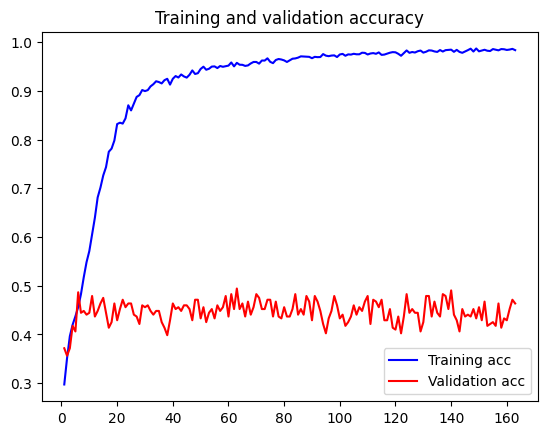

<Figure size 640x480 with 0 Axes>

In [ ]:
epochs = range(1, len(save_metric.accuracy) + 1)
plt.plot(epochs, save_metric.accuracy, 'b', label='Training acc')
plt.plot(epochs, save_metric.val_accuracy, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()


<Figure size 640x480 with 0 Axes>

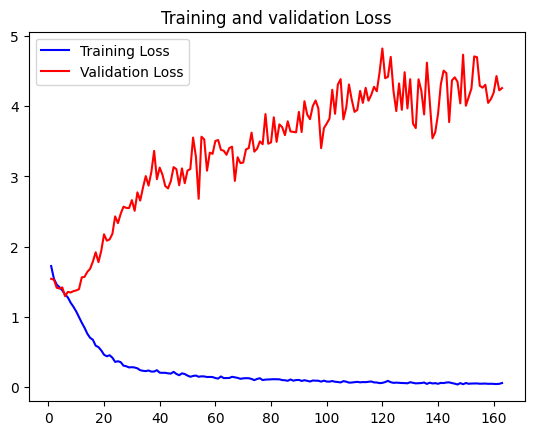

<Figure size 640x480 with 0 Axes>

In [ ]:
epochs = range(1, len(save_metric.loss) + 1)
plt.plot(epochs, save_metric.loss, 'b', label='Training Loss')
plt.plot(epochs, save_metric.val_loss, 'r', label='Validation Loss')
plt.title('Training and validation Loss')
plt.legend()
plt.figure()

<Figure size 640x480 with 0 Axes>

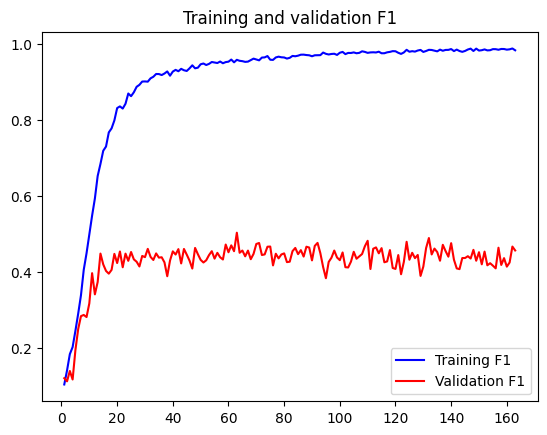

<Figure size 640x480 with 0 Axes>

In [ ]:
epochs=range(1,len(save_metric.f1)+1)
plt.plot(epochs,save_metric.f1,'b',label='Training F1')
plt.plot(epochs,save_metric.val_f1,'r',label='Validation F1')
plt.title('Training and validation F1')
plt.legend()
plt.figure()


In [ ]:
# reload the best model
filepath="/content/drive/MyDrive/Kaggle_ds/2dmodel1_lr0.0001.best.hdf5"

CNNmodel.load_weights(filepath)

# evaluate model on test data

from sklearn.metrics import classification_report

y_pred = CNNmodel.predict(x_testcnn, batch_size=16, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

y_test_bool = np.argmax(y_test_lb, axis=1)
print(classification_report(y_test_bool, y_pred_bool))

140/140 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.52      0.65      0.57       382
           1       0.37      0.26      0.30       381
           2       0.28      0.25      0.27       381
           3       0.30      0.35      0.32       382
           4       0.42      0.45      0.44       326
           5       0.48      0.45      0.47       381

    accuracy                           0.40      2233
   macro avg       0.39      0.40      0.39      2233
weighted avg       0.39      0.40      0.39      2233



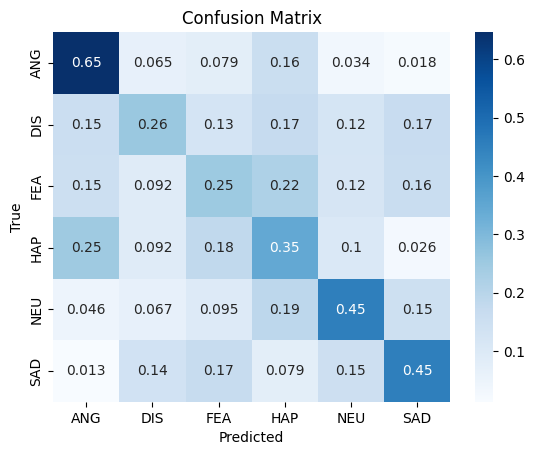

In [ ]:
cm = confusion_matrix(y_test_bool, y_pred_bool)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm, annot=True, cmap='Blues',xticklabels=['ANG','DIS','FEA','HAP','NEU','SAD'],yticklabels=['ANG','DIS','FEA','HAP','NEU','SAD'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

###Comment

Decreasing the lr value to 0.0001 didn't make a  change and yielded acc 0.40
The most confusing classes here are Fear 0.25,disgust 0.26
This model yields acc 0.40 and F1-score with weighted avg 0.39 and with macro average 0.39

# Initial CNN MODEL with lr=0.0005

In [ ]:
def get_f1(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [ ]:
def create_model2d():
  input_shape=(30,216,1)
  CNNmodel = models.Sequential()
  CNNmodel.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
  CNNmodel.add(layers.MaxPooling2D((2, 2)))
  CNNmodel.add(layers.Dropout(0.2))
  CNNmodel.add(layers.Conv2D(64, (3, 3), activation='relu'))
  CNNmodel.add(layers.MaxPooling2D((2, 2)))
  CNNmodel.add(layers.Dropout(0.2))
  CNNmodel.add(layers.Conv2D(64, (3, 3), activation='relu'))
  CNNmodel.add(layers.Flatten())
  CNNmodel.add(layers.Dense(64, activation='relu'))
  CNNmodel.add(layers.Dropout(0.2))
  CNNmodel.add(layers.Dense(32, activation='relu'))
  CNNmodel.add(layers.Dense(6, activation='softmax')) 
  opt=tensorflow.keras.optimizers.RMSprop(
    learning_rate=0.0005
)
  CNNmodel.compile(loss = 'categorical_crossentropy',optimizer = 'Adam',metrics = ['accuracy',get_f1])
  return CNNmodel

In [ ]:
# call back function after epoch end for storing accuracy and loss and f1 score trainig and validation
class myCallback(tensorflow.keras.callbacks.Callback):
    accuracy = []
    val_accuracy = []
    loss = []
    val_loss = []
    f1 = []
    val_f1 = []
    epoch_num = 0
    def __init__(self, logs={}):
        self.accuracy = []
        self.val_accuracy = []
        self.loss = []
        self.val_loss = []
        self.f1 = []
        self.val_f1 = []
        self.epoch_num = 0

    def on_epoch_end(self,epoch,logs={}):
        # get current accuracy and loss
        current_accuracy = logs.get('accuracy')
        current_val_accuracy = logs.get('val_accuracy')
        current_loss = logs.get('loss')
        current_val_loss = logs.get('val_loss')
        current_f1 = logs.get('get_f1')
        current_val_f1 = logs.get('val_get_f1')

        # append current accuracy and loss to lists
        self.accuracy.append(current_accuracy)
        self.val_accuracy.append(current_val_accuracy)
        self.loss.append(current_loss)
        self.val_loss.append(current_val_loss)
        self.f1.append(current_f1)
        self.val_f1.append(current_val_f1)

        # update epoch number
        self.epoch_num = self.epoch_num + 1



In [ ]:
X_train_val, X_test, y_train_val, y_test = train_test_split(spectro,labels, test_size=0.3, random_state=42, stratify=labels)
# Split the remaining data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.05, random_state=42, stratify=y_train_val)
print(len(X_train_val))
print(len(X_val))
print(len(X_test))

5209
261
2233


In [ ]:
# expand dimensions
x_traincnn = np.expand_dims(X_train, axis=3)
x_valcnn = np.expand_dims(X_val, axis=3)
x_testcnn=np.expand_dims(X_test,axis=3)


In [ ]:
lb = LabelEncoder()
# encode labels

y_train_lb = np_utils.to_categorical(lb.fit_transform(y_train))
y_val_lb = np_utils.to_categorical(lb.fit_transform(y_val))
y_test_lb=np_utils.to_categorical(lb.fit_transform(y_test))

In [ ]:
x_traincnn.dtype

dtype('float64')

In [ ]:
# train model
CNNmodel=create_model2d()
tensorflow.convert_to_tensor(x_traincnn, dtype=tensorflow.float64)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=20, min_lr=0.000001)
save_metric = myCallback()
es = EarlyStopping(monitor='val_accuracy', patience=100)
filepath="/content/drive/MyDrive/Kaggle_ds/2dmodel1_lr0.0005.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
cnn_results=CNNmodel.fit(x_traincnn, y_train_lb, batch_size=16, epochs=700,
                     validation_data = (x_valcnn, y_val_lb), callbacks=[lr_reduce,checkpoint,es,save_metric])

Epoch 1/700
302/310 [============================>.] - ETA: 0s - loss: 1.9805 - accuracy: 0.2887 - get_f1: 0.1041
Epoch 1: val_accuracy improved from -inf to 0.31801, saving model to /content/drive/MyDrive/Kaggle_ds/2dmodel1_lr0.0005.best.hdf5
310/310 [==============================] - 6s 8ms/step - loss: 1.9712 - accuracy: 0.2896 - get_f1: 0.1059 - val_loss: 1.5928 - val_accuracy: 0.3180 - val_get_f1: 0.1462 - lr: 0.0010
Epoch 2/700
305/310 [============================>.] - ETA: 0s - loss: 1.5721 - accuracy: 0.3402 - get_f1: 0.1301
Epoch 2: val_accuracy improved from 0.31801 to 0.43678, saving model to /content/drive/MyDrive/Kaggle_ds/2dmodel1_lr0.0005.best.hdf5
310/310 [==============================] - 2s 7ms/step - loss: 1.5709 - accuracy: 0.3401 - get_f1: 0.1303 - val_loss: 1.4531 - val_accuracy: 0.4368 - val_get_f1: 0.1262 - lr: 0.0010
Epoch 3/700
302/310 [============================>.] - ETA: 0s - loss: 1.4909 - accuracy: 0.3818 - get_f1: 0.1710
Epoch 3: val_accuracy did not i

<Figure size 640x480 with 0 Axes>

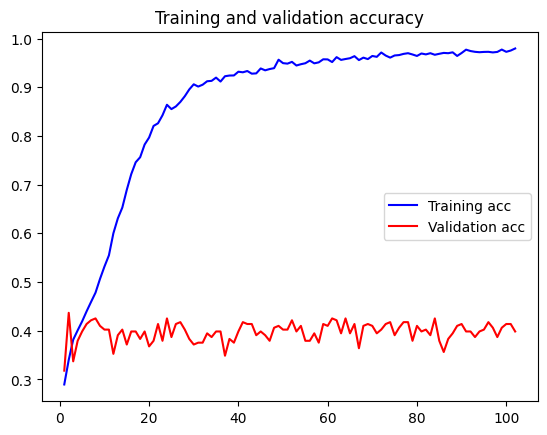

<Figure size 640x480 with 0 Axes>

In [ ]:
epochs = range(1, len(save_metric.accuracy) + 1)
plt.plot(epochs, save_metric.accuracy, 'b', label='Training acc')
plt.plot(epochs, save_metric.val_accuracy, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()


<Figure size 640x480 with 0 Axes>

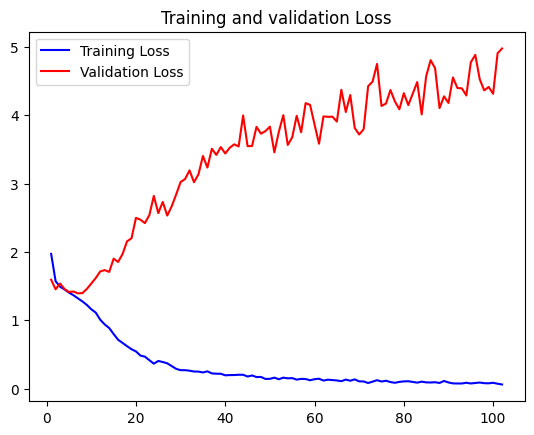

<Figure size 640x480 with 0 Axes>

In [ ]:
epochs = range(1, len(save_metric.loss) + 1)
plt.plot(epochs, save_metric.loss, 'b', label='Training Loss')
plt.plot(epochs, save_metric.val_loss, 'r', label='Validation Loss')
plt.title('Training and validation Loss')
plt.legend()
plt.figure()

<Figure size 640x480 with 0 Axes>

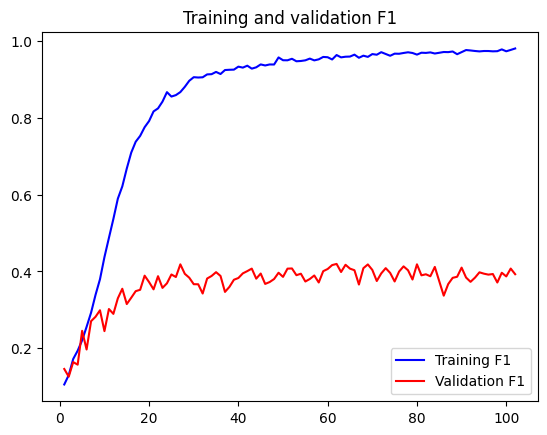

<Figure size 640x480 with 0 Axes>

In [ ]:
epochs=range(1,len(save_metric.f1)+1)
plt.plot(epochs,save_metric.f1,'b',label='Training F1')
plt.plot(epochs,save_metric.val_f1,'r',label='Validation F1')
plt.title('Training and validation F1')
plt.legend()
plt.figure()


In [ ]:
# reload the best model
filepath="/content/drive/MyDrive/Kaggle_ds/2dmodel1_lr0.0005.best.hdf5"

CNNmodel.load_weights(filepath)

# evaluate model on test data

from sklearn.metrics import classification_report

y_pred = CNNmodel.predict(x_testcnn, batch_size=16, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

y_test_bool = np.argmax(y_test_lb, axis=1)
print(classification_report(y_test_bool, y_pred_bool))

140/140 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.62      0.64      0.63       382
           1       0.33      0.02      0.03       381
           2       0.24      0.03      0.06       381
           3       0.31      0.54      0.40       382
           4       0.37      0.51      0.43       326
           5       0.44      0.75      0.55       381

    accuracy                           0.41      2233
   macro avg       0.39      0.42      0.35      2233
weighted avg       0.39      0.41      0.35      2233



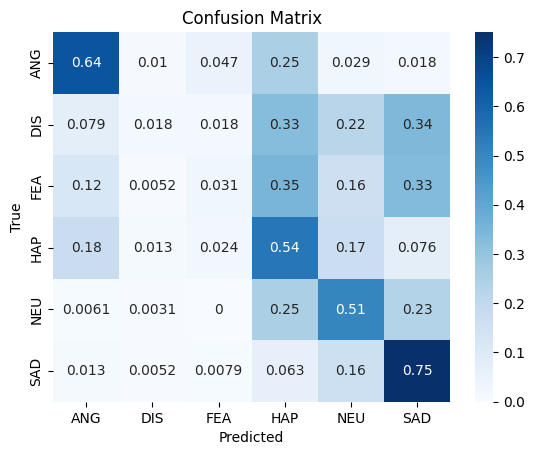

In [ ]:
cm = confusion_matrix(y_test_bool, y_pred_bool)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm, annot=True, cmap='Blues',xticklabels=['ANG','DIS','FEA','HAP','NEU','SAD'],yticklabels=['ANG','DIS','FEA','HAP','NEU','SAD'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

###Comment

 The most confusing classes here are Fear 0.031,disgust 0.018 
This model yields acc 0.40 and F1-score with weighted avg 0.35 and with macro average 0.35

#CNN MODEL2

In [ ]:
def get_f1(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [ ]:
def get_2d_conv_model(n):
    ''' Create a standard deep 2D convolutional neural network'''
    nclass = 6
    inp = Input(shape=(n,216,1))  #2D matrix of 30 MFCC bands by 216 audio length.
    x = Convolution2D(32, (4,10), padding="same")(inp)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    x = Dropout(rate=0.2)(x)
    
    x = Convolution2D(32, (4,10), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    x = Dropout(rate=0.2)(x)
    
    x = Convolution2D(32, (4,10), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    x = Dropout(rate=0.2)(x)
    
    x = Convolution2D(32, (4,10), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    x = Dropout(rate=0.2)(x)
    
    x = Flatten()(x)
    x = Dense(64)(x)
    x = Dropout(rate=0.2)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(rate=0.2)(x)
    
    out = Dense(nclass, activation=softmax)(x)
    model = models.Model(inputs=inp, outputs=out)
    
    opt = optimizers.Adam(0.001)
    model.compile(optimizer=opt, loss=losses.categorical_crossentropy, metrics=['acc',get_f1])
    return model

In [ ]:
# call back function after epoch end for storing accuracy and loss and f1 score trainig and validation
class myCallback(tensorflow.keras.callbacks.Callback):
    accuracy = []
    val_accuracy = []
    loss = []
    val_loss = []
    f1 = []
    val_f1 = []
    epoch_num = 0
    def __init__(self, logs={}):
        self.accuracy = []
        self.val_accuracy = []
        self.loss = []
        self.val_loss = []
        self.f1 = []
        self.val_f1 = []
        self.epoch_num = 0

    def on_epoch_end(self,epoch,logs={}):
        # get current accuracy and loss
        current_accuracy = logs.get('acc')
        current_val_accuracy = logs.get('val_acc')
        current_loss = logs.get('loss')
        current_val_loss = logs.get('val_loss')
        current_f1 = logs.get('get_f1')
        current_val_f1 = logs.get('val_get_f1')

        # append current accuracy and loss to lists
        self.accuracy.append(current_accuracy)
        self.val_accuracy.append(current_val_accuracy)
        self.loss.append(current_loss)
        self.val_loss.append(current_val_loss)
        self.f1.append(current_f1)
        self.val_f1.append(current_val_f1)

        # update epoch number
        self.epoch_num = self.epoch_num + 1



In [ ]:
X_train_val, X_test, y_train_val, y_test = train_test_split(spectro,labels, test_size=0.3, random_state=42, stratify=labels)
# Split the remaining data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.05, random_state=42, stratify=y_train_val)
print(len(X_train_val))
print(len(X_val))
print(len(X_test))

5209
261
2233


In [ ]:
# expand dimensions
x_traincnn = np.expand_dims(X_train, axis=3)
x_valcnn = np.expand_dims(X_val, axis=3)
x_testcnn=np.expand_dims(X_test,axis=3)


In [ ]:
lb = LabelEncoder()
# encode labels

y_train_lb = np_utils.to_categorical(lb.fit_transform(y_train))
y_val_lb = np_utils.to_categorical(lb.fit_transform(y_val))
y_test_lb=np_utils.to_categorical(lb.fit_transform(y_test))

In [ ]:
x_traincnn.dtype

dtype('float64')

In [ ]:
# train model
CNNmodel=get_2d_conv_model(30)
tensorflow.convert_to_tensor(x_traincnn, dtype=tensorflow.float64)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=20, min_lr=0.000001)
save_metric = myCallback()
es = EarlyStopping(monitor='val_acc', patience=100)
filepath="/content/drive/MyDrive/Kaggle_ds/2dmodel2.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
cnn_results=CNNmodel.fit(x_traincnn, y_train_lb, batch_size=16, epochs=700,
                     validation_data = (x_valcnn, y_val_lb), callbacks=[lr_reduce,checkpoint,es,save_metric])

Epoch 1/700
306/310 [============================>.] - ETA: 0s - loss: 1.6873 - acc: 0.3033 - get_f1: 0.1641
Epoch 1: val_acc improved from -inf to 0.35632, saving model to /content/drive/MyDrive/Kaggle_ds/2dmodel2.best.hdf5
310/310 [==============================] - 6s 15ms/step - loss: 1.6861 - acc: 0.3034 - get_f1: 0.1651 - val_loss: 1.6062 - val_acc: 0.3563 - val_get_f1: 0.1879 - lr: 0.0010
Epoch 2/700
309/310 [============================>.] - ETA: 0s - loss: 1.5728 - acc: 0.3445 - get_f1: 0.1711
Epoch 2: val_acc improved from 0.35632 to 0.38314, saving model to /content/drive/MyDrive/Kaggle_ds/2dmodel2.best.hdf5
310/310 [==============================] - 3s 11ms/step - loss: 1.5731 - acc: 0.3444 - get_f1: 0.1706 - val_loss: 1.4427 - val_acc: 0.3831 - val_get_f1: 0.2398 - lr: 0.0010
Epoch 3/700
306/310 [============================>.] - ETA: 0s - loss: 1.4847 - acc: 0.3958 - get_f1: 0.2005
Epoch 3: val_acc did not improve from 0.38314
310/310 [==============================] - 3s 

<Figure size 640x480 with 0 Axes>

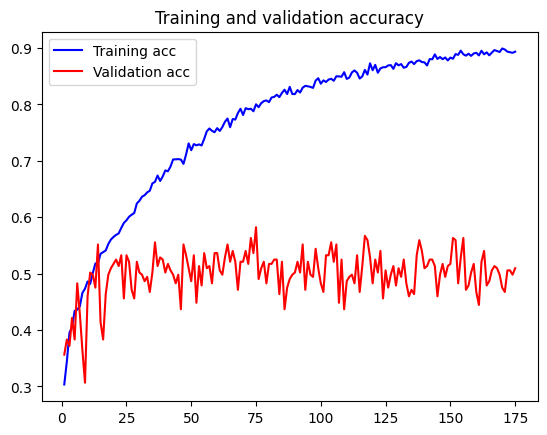

<Figure size 640x480 with 0 Axes>

In [ ]:
epochs = range(1, len(save_metric.accuracy) + 1)
plt.plot(epochs, save_metric.accuracy, 'b', label='Training acc')
plt.plot(epochs, save_metric.val_accuracy, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()


<Figure size 640x480 with 0 Axes>

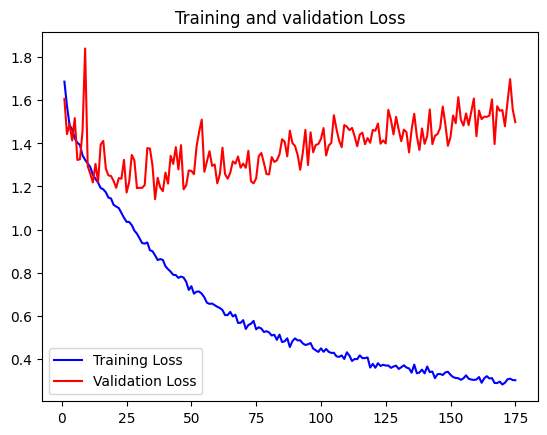

<Figure size 640x480 with 0 Axes>

In [ ]:
epochs = range(1, len(save_metric.loss) + 1)
plt.plot(epochs, save_metric.loss, 'b', label='Training Loss')
plt.plot(epochs, save_metric.val_loss, 'r', label='Validation Loss')
plt.title('Training and validation Loss')
plt.legend()
plt.figure()

<Figure size 640x480 with 0 Axes>

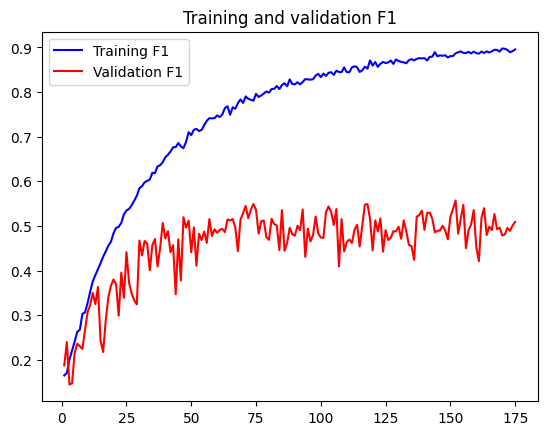

<Figure size 640x480 with 0 Axes>

In [ ]:
epochs=range(1,len(save_metric.f1)+1)
plt.plot(epochs,save_metric.f1,'b',label='Training F1')
plt.plot(epochs,save_metric.val_f1,'r',label='Validation F1')
plt.title('Training and validation F1')
plt.legend()
plt.figure()


In [ ]:
# reload the best model
filepath="/content/drive/MyDrive/Kaggle_ds/2dmodel2.best.hdf5"

CNNmodel.load_weights(filepath)

# evaluate model on test data

from sklearn.metrics import classification_report

y_pred = CNNmodel.predict(x_testcnn, batch_size=16, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

y_test_bool = np.argmax(y_test_lb, axis=1)
print(classification_report(y_test_bool, y_pred_bool))

140/140 [==============================] - 1s 4ms/step
              precision    recall  f1-score   support

           0       0.71      0.69      0.70       382
           1       0.54      0.49      0.51       381
           2       0.43      0.60      0.50       381
           3       0.47      0.47      0.47       382
           4       0.68      0.57      0.62       326
           5       0.58      0.50      0.54       381

    accuracy                           0.55      2233
   macro avg       0.57      0.55      0.56      2233
weighted avg       0.57      0.55      0.56      2233



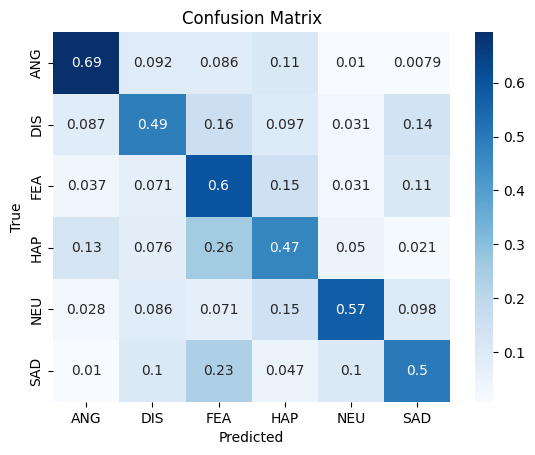

In [ ]:
cm = confusion_matrix(y_test_bool, y_pred_bool)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm, annot=True, cmap='Blues',xticklabels=['ANG','DIS','FEA','HAP','NEU','SAD'],yticklabels=['ANG','DIS','FEA','HAP','NEU','SAD'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

###Comment

This is the best model with validation acc 0.58238 and tetsing acc 0.55 ,F1 score weighted and macro =0.56
The most confusing classes are HAP 0.47 and DIS 0.49

we believe this model yielded the best result because:

Different levels of feature levels in the audio input can be captured using many convolutional layers with an increasing number of filters.
The training process can be stabilised and the generalisation of the model is enhanced with batch normalisation.
Max pooling reduces the spatial dimensions of the feature maps, allowing the model to focus on the most important features.
Dropout regularization helps in reducing overfitting by randomly setting a fraction of the inputs to 0 during training.



#VGG16 (ATTEMPT)

In [ ]:
def get_f1(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [ ]:
from keras import optimizers, losses, activations, models
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Input, Dropout, BatchNormalization, Convolution2D, MaxPooling2D, GlobalMaxPool2D
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from tensorflow.keras.regularizers import l1_l2
def get_2D_model():
    model = Sequential()
    model.add(Conv2D(input_shape=(30,216,1),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
    model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    # model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(layers.Dropout(0.2))
    model.add(layers.Flatten())
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(6, activation='softmax')) 
    opt=tensorflow.keras.optimizers.Adam(
    learning_rate=0.005
)
    model.compile(loss = 'categorical_crossentropy',optimizer =opt,metrics = ['accuracy'])
    # model.summary()
  
    return model

In [ ]:
# call back function after epoch end for storing accuracy and loss and f1 score trainig and validation
class myCallback(tensorflow.keras.callbacks.Callback):
    accuracy = []
    val_accuracy = []
    loss = []
    val_loss = []
    f1 = []
    val_f1 = []
    epoch_num = 0
    def __init__(self, logs={}):
        self.accuracy = []
        self.val_accuracy = []
        self.loss = []
        self.val_loss = []
        self.f1 = []
        self.val_f1 = []
        self.epoch_num = 0

    def on_epoch_end(self,epoch,logs={}):
        # get current accuracy and loss
        current_accuracy = logs.get('accuracy')
        current_val_accuracy = logs.get('val_accuracy')
        current_loss = logs.get('loss')
        current_val_loss = logs.get('val_loss')
        current_f1 = logs.get('get_f1')
        current_val_f1 = logs.get('val_get_f1')

        # append current accuracy and loss to lists
        self.accuracy.append(current_accuracy)
        self.val_accuracy.append(current_val_accuracy)
        self.loss.append(current_loss)
        self.val_loss.append(current_val_loss)
        self.f1.append(current_f1)
        self.val_f1.append(current_val_f1)

        # update epoch number
        self.epoch_num = self.epoch_num + 1



In [ ]:
X_train_val, X_test, y_train_val, y_test = train_test_split(spectro,labels, test_size=0.3, random_state=42, stratify=labels)
# Split the remaining data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.05, random_state=42, stratify=y_train_val)
print(len(X_train_val))
print(len(X_val))
print(len(X_test))

5209
261
2233


In [ ]:
# expand dimensions
x_traincnn = np.expand_dims(X_train, axis=3)
x_valcnn = np.expand_dims(X_val, axis=3)
x_testcnn=np.expand_dims(X_test,axis=3)


In [ ]:
lb = LabelEncoder()
# encode labels

y_train_lb = np_utils.to_categorical(lb.fit_transform(y_train))
y_val_lb = np_utils.to_categorical(lb.fit_transform(y_val))
y_test_lb=np_utils.to_categorical(lb.fit_transform(y_test))

In [ ]:
x_traincnn.dtype

dtype('float64')

In [ ]:
# train model
model=get_2D_model()
tensorflow.convert_to_tensor(x_traincnn, dtype=tensorflow.float64)
history = model.fit(x_traincnn, y_train_lb, epochs=20,validation_data= (x_valcnn, y_val_lb))

Epoch 1/20
155/155 [==============================] - 121s 84ms/step - loss: 465.3482 - accuracy: 0.1766 - val_loss: 1.7910 - val_accuracy: 0.1686
Epoch 2/20
155/155 [==============================] - 12s 80ms/step - loss: 1.7910 - accuracy: 0.1655 - val_loss: 1.7902 - val_accuracy: 0.1724
Epoch 3/20
155/155 [==============================] - 13s 81ms/step - loss: 1.7907 - accuracy: 0.1694 - val_loss: 1.7902 - val_accuracy: 0.1724
Epoch 4/20
155/155 [==============================] - 13s 81ms/step - loss: 1.7908 - accuracy: 0.1645 - val_loss: 1.7903 - val_accuracy: 0.1686
Epoch 5/20
155/155 [==============================] - 13s 82ms/step - loss: 1.7908 - accuracy: 0.1627 - val_loss: 1.7901 - val_accuracy: 0.1724
Epoch 6/20
155/155 [==============================] - 13s 83ms/step - loss: 1.7908 - accuracy: 0.1665 - val_loss: 1.7902 - val_accuracy: 0.1686
Epoch 7/20
155/155 [==============================] - 13s 82ms/step - loss: 1.7909 - accuracy: 0.1702 - val_loss: 1.7903 - val_accura

In [ ]:
# train model
CNNmodel=get_2D_model()
tensorflow.convert_to_tensor(x_traincnn, dtype=tensorflow.float64)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=20, min_lr=0.000001)
save_metric = myCallback()
es = EarlyStopping(monitor='val_accuracy', patience=100)
filepath="/content/drive/MyDrive/Kaggle_ds/2dmodelVGG.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
cnn_results=CNNmodel.fit(x_traincnn, y_train_lb, batch_size=16, epochs=700,
                     validation_data = (x_valcnn, y_val_lb), callbacks=[lr_reduce,checkpoint,es,save_metric])

Epoch 1/700
  6/310 [..............................] - ETA: 14s - loss: 3995.2000 - accuracy: 0.1667

310/310 [==============================] - ETA: 0s - loss: 79.6680 - accuracy: 0.1754
Epoch 1: val_accuracy improved from -inf to 0.17241, saving model to /content/drive/MyDrive/Kaggle_ds/2dmodelVGG.best.hdf5
310/310 [==============================] - 26s 59ms/step - loss: 79.6680 - accuracy: 0.1754 - val_loss: 1.7904 - val_accuracy: 0.1724 - lr: 0.0050
Epoch 2/700
309/310 [============================>.] - ETA: 0s - loss: 1.7913 - accuracy: 0.1677
Epoch 2: val_accuracy did not improve from 0.17241
310/310 [==============================] - 16s 52ms/step - loss: 1.7913 - accuracy: 0.1675 - val_loss: 1.7903 - val_accuracy: 0.1686 - lr: 0.0050
Epoch 3/700
309/310 [============================>.] - ETA: 0s - loss: 1.7914 - accuracy: 0.1606
Epoch 3: val_accuracy did not improve from 0.17241
310/310 [==============================] - 16s 52ms/step - loss: 1.7914 - accuracy: 0.1605 - val_loss: 1.7902 - val_accuracy: 0.1724 - lr: 0.0050
Epoch 4/700
309/310 [============================>.] - E

<Figure size 640x480 with 0 Axes>

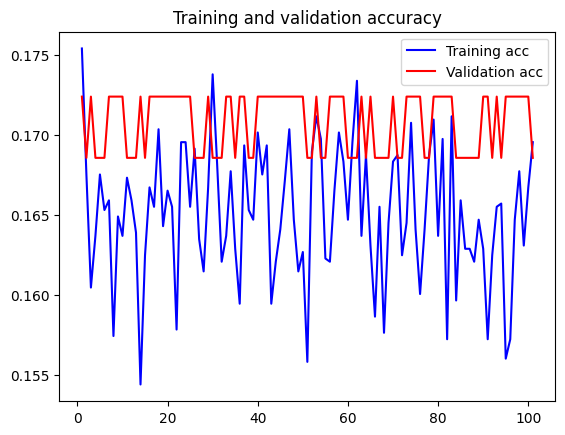

<Figure size 640x480 with 0 Axes>

In [ ]:
epochs = range(1, len(save_metric.accuracy) + 1)
plt.plot(epochs, save_metric.accuracy, 'b', label='Training acc')
plt.plot(epochs, save_metric.val_accuracy, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()


<Figure size 640x480 with 0 Axes>

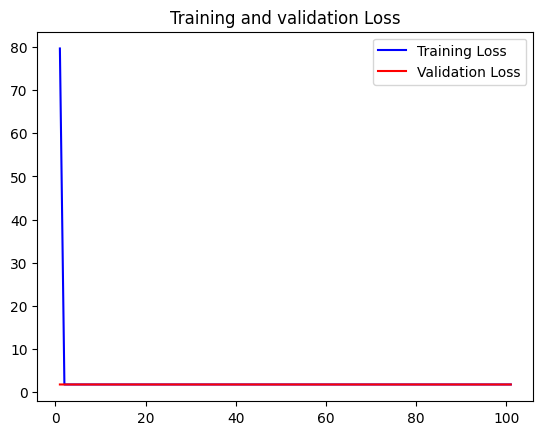

<Figure size 640x480 with 0 Axes>

In [ ]:
epochs = range(1, len(save_metric.loss) + 1)
plt.plot(epochs, save_metric.loss, 'b', label='Training Loss')
plt.plot(epochs, save_metric.val_loss, 'r', label='Validation Loss')
plt.title('Training and validation Loss')
plt.legend()
plt.figure()

In [ ]:
# reload the best model
filepath="/content/drive/MyDrive/Kaggle_ds/2dmodelVGG.best.hdf5"

CNNmodel.load_weights(filepath)

# evaluate model on test data

from sklearn.metrics import classification_report

y_pred = CNNmodel.predict(x_testcnn, batch_size=16, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

y_test_bool = np.argmax(y_test_lb, axis=1)
print(classification_report(y_test_bool, y_pred_bool))

140/140 [==============================] - 3s 17ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       382
           1       0.00      0.00      0.00       381
           2       0.00      0.00      0.00       381
           3       0.00      0.00      0.00       382
           4       0.00      0.00      0.00       326
           5       0.17      1.00      0.29       381

    accuracy                           0.17      2233
   macro avg       0.03      0.17      0.05      2233
weighted avg       0.03      0.17      0.05      2233



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


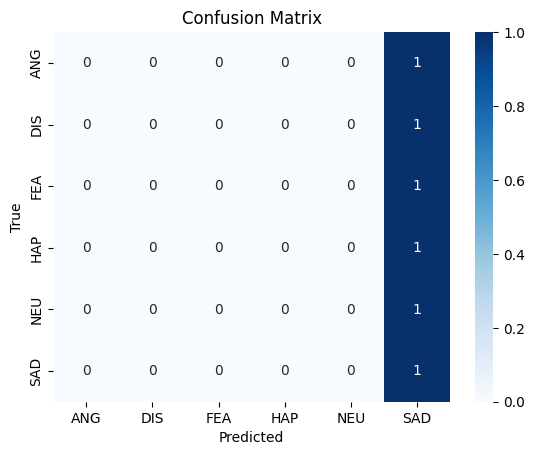

In [ ]:
cm = confusion_matrix(y_test_bool, y_pred_bool)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm, annot=True, cmap='Blues',xticklabels=['ANG','DIS','FEA','HAP','NEU','SAD'],yticklabels=['ANG','DIS','FEA','HAP','NEU','SAD'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

###Comment

VGG16 attempt yeilds the worst acc and f1_score 

#CNN MODEL3

In [89]:
def get_f1(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [90]:
def get_2d_conv_model():
    model = Sequential()
    model.add(Conv2D(32,11, 11, input_shape = (30,216,1),padding='same',activation = 'relu'))
    model.add(Conv2D(32,7, 7,padding='same',kernel_regularizer=regularizers.l2(0.001)))
    model.add(Conv2D(32,7, 7,padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
    model.add(Dropout(0.4))
    model.add(Conv2D(64,5, 5,padding='same',kernel_regularizer=regularizers.l2(0.001)))
    model.add(Conv2D(64,3, 3,padding='same'))
    model.add(Conv2D(64,3, 3,padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
    model.add(Dropout(0.4))
    model.add(Conv2D(64,3, 3,padding='same',kernel_regularizer=regularizers.l2(0.001)))
    model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
    model.add(Flatten())
    model.add(Dense(10000,activation = 'relu',kernel_regularizer=regularizers.l2(0.001)))
    model.add(Dropout(0.5))
    model.add(Dense(6, activation = 'softmax'))

    
    opt=tensorflow.keras.optimizers.Adam(
    learning_rate=0.001
)
    model.compile(loss = 'categorical_crossentropy',optimizer =opt,metrics = ['accuracy'])
    return model

In [91]:
# call back function after epoch end for storing accuracy and loss and f1 score trainig and validation
class myCallback(tensorflow.keras.callbacks.Callback):
    accuracy = []
    val_accuracy = []
    loss = []
    val_loss = []
    f1 = []
    val_f1 = []
    epoch_num = 0
    def __init__(self, logs={}):
        self.accuracy = []
        self.val_accuracy = []
        self.loss = []
        self.val_loss = []
        self.f1 = []
        self.val_f1 = []
        self.epoch_num = 0

    def on_epoch_end(self,epoch,logs={}):
        # get current accuracy and loss
        current_accuracy = logs.get('accuracy')
        current_val_accuracy = logs.get('val_accuracy')
        current_loss = logs.get('loss')
        current_val_loss = logs.get('val_loss')
        current_f1 = logs.get('get_f1')
        current_val_f1 = logs.get('val_get_f1')

        # append current accuracy and loss to lists
        self.accuracy.append(current_accuracy)
        self.val_accuracy.append(current_val_accuracy)
        self.loss.append(current_loss)
        self.val_loss.append(current_val_loss)
        self.f1.append(current_f1)
        self.val_f1.append(current_val_f1)

        # update epoch number
        self.epoch_num = self.epoch_num + 1



In [92]:
X_train_val, X_test, y_train_val, y_test = train_test_split(spectro,labels, test_size=0.3, random_state=42, stratify=labels)
# Split the remaining data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.05, random_state=42, stratify=y_train_val)
print(len(X_train_val))
print(len(X_val))
print(len(X_test))

5209
261
2233


In [93]:
# expand dimensions
x_traincnn = np.expand_dims(X_train, axis=3)
x_valcnn = np.expand_dims(X_val, axis=3)
x_testcnn=np.expand_dims(X_test,axis=3)


In [94]:
lb = LabelEncoder()
# encode labels

y_train_lb = np_utils.to_categorical(lb.fit_transform(y_train))
y_val_lb = np_utils.to_categorical(lb.fit_transform(y_val))
y_test_lb=np_utils.to_categorical(lb.fit_transform(y_test))

In [95]:
x_traincnn.dtype

dtype('float64')

In [96]:
# train model
CNNmodel=get_2d_conv_model()
tensorflow.convert_to_tensor(x_traincnn, dtype=tensorflow.float64)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=20, min_lr=0.000001)
save_metric = myCallback()
es = EarlyStopping(monitor='val_accuracy', patience=100)
filepath="/content/drive/MyDrive/Kaggle_ds/2dmodel3.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
cnn_results=CNNmodel.fit(x_traincnn, y_train_lb, batch_size=16, epochs=700,
                     validation_data = (x_valcnn, y_val_lb), callbacks=[lr_reduce,checkpoint,es,save_metric])

Epoch 1/700
307/310 [============================>.] - ETA: 0s - loss: 1.6801 - accuracy: 0.3035
Epoch 1: val_accuracy improved from -inf to 0.36015, saving model to /content/drive/MyDrive/Kaggle_ds/2dmodel3.best.hdf5
310/310 [==============================] - 7s 16ms/step - loss: 1.6798 - accuracy: 0.3036 - val_loss: 1.5668 - val_accuracy: 0.3602 - lr: 0.0010
Epoch 2/700
310/310 [==============================] - ETA: 0s - loss: 1.5726 - accuracy: 0.3476
Epoch 2: val_accuracy improved from 0.36015 to 0.37165, saving model to /content/drive/MyDrive/Kaggle_ds/2dmodel3.best.hdf5
310/310 [==============================] - 4s 14ms/step - loss: 1.5726 - accuracy: 0.3476 - val_loss: 1.5078 - val_accuracy: 0.3716 - lr: 0.0010
Epoch 3/700
308/310 [============================>.] - ETA: 0s - loss: 1.5573 - accuracy: 0.3543
Epoch 3: val_accuracy did not improve from 0.37165
310/310 [==============================] - 6s 18ms/step - loss: 1.5577 - accuracy: 0.3539 - val_loss: 1.5222 - val_accuracy

<Figure size 640x480 with 0 Axes>

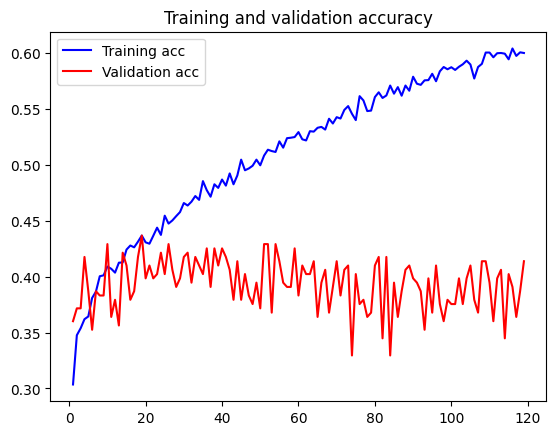

<Figure size 640x480 with 0 Axes>

In [101]:
epochs = range(1, len(save_metric.accuracy) + 1)
plt.plot(epochs, save_metric.accuracy, 'b', label='Training acc')
plt.plot(epochs, save_metric.val_accuracy, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()


<Figure size 640x480 with 0 Axes>

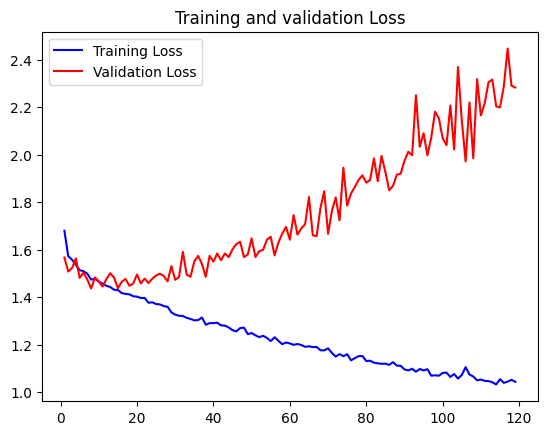

<Figure size 640x480 with 0 Axes>

In [102]:
epochs = range(1, len(save_metric.loss) + 1)
plt.plot(epochs, save_metric.loss, 'b', label='Training Loss')
plt.plot(epochs, save_metric.val_loss, 'r', label='Validation Loss')
plt.title('Training and validation Loss')
plt.legend()
plt.figure()

In [97]:
# reload the best model
filepath="/content/drive/MyDrive/Kaggle_ds/2dmodel3.best.hdf5"

CNNmodel.load_weights(filepath)

# evaluate model on test data

from sklearn.metrics import classification_report

y_pred = CNNmodel.predict(x_testcnn, batch_size=16, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

y_test_bool = np.argmax(y_test_lb, axis=1)
print(classification_report(y_test_bool, y_pred_bool))

140/140 [==============================] - 1s 4ms/step
              precision    recall  f1-score   support

           0       0.63      0.60      0.61       382
           1       0.32      0.25      0.28       381
           2       0.25      0.01      0.02       381
           3       0.33      0.47      0.39       382
           4       0.40      0.51      0.44       326
           5       0.45      0.71      0.55       381

    accuracy                           0.42      2233
   macro avg       0.40      0.42      0.38      2233
weighted avg       0.40      0.42      0.38      2233



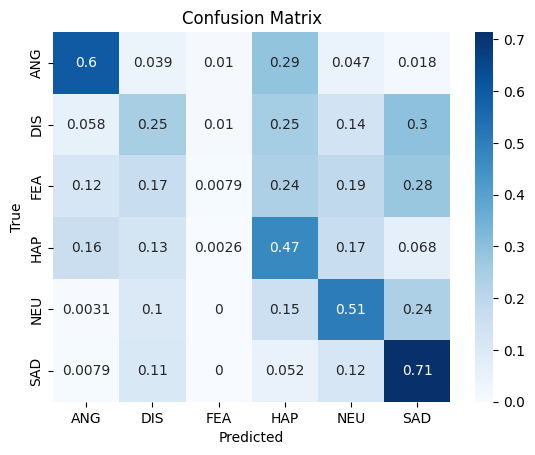

In [98]:
cm = confusion_matrix(y_test_bool, y_pred_bool)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm, annot=True, cmap='Blues',xticklabels=['ANG','DIS','FEA','HAP','NEU','SAD'],yticklabels=['ANG','DIS','FEA','HAP','NEU','SAD'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()